# Projekt

Celem niniejszego projektu jest nauczenie sieci neuronowej dla rozpoznawania obrazków zawierających reprezentację liczb 0-9 w języku migowym. Dataset, który był używany dla nauczenia sieci neuronowej, jest dostępny w repozytorium na githubie: https://github.com/ardamavi/Sign-Language-Digits-Dataset. Tworzenie sieci neuronowej było przeprowadzono za pomocą API Keras dla Tensorflow 2.0. Wszystkie obliczenia były przeprowadzone w Jupyter Notebook. 

## Importy potrzebnych modułów

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.image import imread
import cv2

%matplotlib inline

## Import obrazów

** Na początku ustawiono ścieżkę do folderów ze zdjęciami. **

In [12]:
train_dir = '/home/vazh/Desktop/IDL/Dataset'
test_dir = '/home/vazh/Desktop/IDL//Examples'

categories = '0 1 2 3 4 5 6 7 8 9'.split()

** Sprawdzenie czy ścieżka jest dobrze ustawiona. **

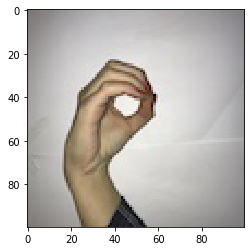

In [13]:
plt.imshow(imread(train_dir + '/0/' + os.listdir(train_dir + '/0')[0]))

** Następnie przeprowadzono konwersję .jpg obrazków do postaci numpy array i dodano je do listów. Obrazki dla nauczenia sieci dodano do listy X, odpowiadające im etykiety do listy Y. Analogicznie postępowano z obrazkami dla testowania danych. Jednocześnie dodano rozmiary wszystkich obrazów do list shape_train_val (dla obrazków dla nauczenia sieci) oraz shape_test (dla obrazków dla testowania sieci). **

In [14]:
X = []
Y = []
X_test = []
Y_test = []
shape_train_val = []
shape_test = []

for cat in categories:
    for image in os.listdir(train_dir + '/' + cat):
        X.append(imread(train_dir + '/' + cat + '/' + image))
        shape_train_val.append(imread(train_dir + '/' + cat + '/' + image).shape)
        Y.append(cat)

for image in os.listdir(test_dir):
    X_test.append(imread(test_dir + '/' + image))
    Y_test.append(image.split('_')[1][0])
    shape_test.append(imread(test_dir + '/' + image).shape)

## Wstępne przetwarzanie danych

** Sprawdzenie rozmiarów obrazków. **

In [15]:
print(Counter(shape_train_val))

Counter({(100, 100, 3): 2059, (3024, 3024, 3): 3})


In [16]:
print(Counter(shape_test))

Counter({(100, 100, 3): 10})


** Rozmiar prawie wszystkich obrazków wynosi (100, 100, 3). Obrazki o rozmiarze (3024, 3024, 3) muszą zmienić rozmiar. **

** Sprawdzenie, w jakiej skali są podane liczby w zdjęciach. **

In [17]:
X[0][0].max()

181

In [18]:
X[0][0].min()

115

** Czyli liczby są podane w skali do 255 i muszą być przeskalowane poprzez dzielenie przez 255. **

** Przeskalowanie obrazków wraz z ustaleniem jednego rozmiaru: (100, 100, 3). Jednocześnie dodano rozmiar wszystkich obrazków dla nauczenia sieci do listy shape_train_val. **

In [19]:
shape_train_val = []


for i in range(0,len(X)):
    X[i] = cv2.resize(X[i], (100, 100))
    X[i] = X[i]/255
    shape_train_val.append(X[i].shape)

for i in range(0,len(X_test)):
    X_test[i] = X_test[i]/255   

** Sprawdzenie, czy udało się przeskalować oraz ustawić jeden rozmiar dla wszystkich obrazków. **

In [22]:
print(Counter(shape_train_val))

Counter({(100, 100, 3): 2062})


In [23]:
X[0][0].max()

0.7098039215686275

** Czyli się udało. Aby móc korzystać z Convolutional Layer w sieci neuronowej, powinniśmy przekształcić listy ze zdjęcia do numpy array o wymiarze: (liczba_elementów, wymiar_1, wymiar2, liczba_kanałów). **

In [24]:
for i in range(0,len(X)):
    X[i].tolist()

for i in range(0, len(X_test)):
    X_test[i].tolist()

X = np.array(X)
X_test = np.array(X_test)
Y = np.array(Y)
Y_test = np.array(Y_test)

X.shape

(2062, 100, 100, 3)

** Także należy przekształcić listę z etykietami do postaci one-hot encoding. ** 

In [25]:
from tensorflow.keras.utils import to_categorical

Y_cat = to_categorical(Y)

## Podział danych na train i validation datasety

** Postanowiono użyć 85% obrazków dla nauczenia sieci, a 15% dla sprawdzenia podczas nauczenia sieci. **

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y_cat, test_size = 0.15)

## Stworzenie modelu sieci neuronowej

** Postanowiono użyć następującego modelu sieci neuronowej ze względu na stanowiący problem. 
Na początku użyto trzy pary warstw Convolutional2D/MaxPooling2D z rozmiarem kernela (2,2), funkcją aktywacji ReLU (rectified linear unit) oraz ze zmniejszającą się liczbą filtrów o połowę, zaczynając od 32. 
Następnie użyto warstwy Flatten w celu stworzenia liniowości, dwie pary warstwy Dense fully-connected/Dropout (z rate = 0.1, żeby zmniejszyć ryzyko przeuczenia się sieci) ze zmniejszająca się liczbą neuronów o połowę zaczynając od 32 wraz z funkcją aktywacji ReLU.
Ze względu na to, że problemem jest klasyfikacja z tylko jedną dozwoloną klasą, wybrano jako warstwę output Dense z liczbą neuronów 10 (tyle jest możliwych klasy) oraz funkcję aktywacji softmax (bo jest tylko jedna dozwolona klasa). ** 

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (2,2), strides = (1,1), input_shape = (100, 100, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 16, kernel_size = (2,2), strides = (1,1), input_shape = (100, 100, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 8, kernel_size = (2,2), strides = (1,1), input_shape = (100, 100, 3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Flatten())

model.add(Dense(units = 32, activation  = 'relu'))
model.add(Dropout(rate = 0.1))
model.add(Dense(units = 16, activation  = 'relu'))
model.add(Dropout(rate = 0.1))
model.add(Dense(units = 10, activation = 'softmax'))

** Jako optymizator postanowiono użyć Adam, ze względu na go ogólną skuteczność. Jako cost function wybrano categorical crossentropy, ze względu na stanowiący problem multiklasyfikacji. **

In [30]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy')

** Aby uniknąć przeuczenia się sieci neuronowej, użyto EarlyStopping, z poszukiwaniem minimum cost function dla validation dataset. Jako minimalną liczbę epoch ustawiono 5. **

In [31]:
early_stop = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

** Całkowita postać modelu. **

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 99, 99, 32)        416       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 16)        2064      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 23, 23, 8)         520       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 11, 11, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 968)              

** Nauczenie sieci neuronowej z użyciem validation dataset, liczbą epoch 60 wraz z EarlyStopping. **

In [33]:
model.fit(x = X_train, y = Y_train, epochs = 60, validation_data = (X_val, Y_val), callbacks = [early_stop])

Train on 1752 samples, validate on 310 samples
Epoch 1/60
1752/1752 [==============================] - 9s 5ms/sample - loss: 2.3059 - val_loss: 2.3038
Epoch 2/60
1752/1752 [==============================] - 7s 4ms/sample - loss: 2.2699 - val_loss: 2.1306
Epoch 3/60
1752/1752 [==============================] - 7s 4ms/sample - loss: 1.7113 - val_loss: 1.3270
Epoch 4/60
1752/1752 [==============================] - 6s 3ms/sample - loss: 1.2241 - val_loss: 0.9557
Epoch 5/60
1752/1752 [==============================] - 6s 3ms/sample - loss: 1.0135 - val_loss: 0.8738
Epoch 6/60
1752/1752 [==============================] - 7s 4ms/sample - loss: 0.8993 - val_loss: 0.6834
Epoch 7/60
1752/1752 [==============================] - 7s 4ms/sample - loss: 0.7935 - val_loss: 0.6212
Epoch 8/60
1752/1752 [==============================] - 8s 4ms/sample - loss: 0.7264 - val_loss: 0.5885
Epoch 9/60
1752/1752 [==============================] - 7s 4ms/sample - loss: 0.6518 - val_loss: 0.5308
Epoch 10/60
1752/

** Analiza przebiegu nauczenia się sieci neuronowej na podstawie wyznaczenia zależności pomiędzy błędem dla train i validation datasetów i liczbą epoch. **

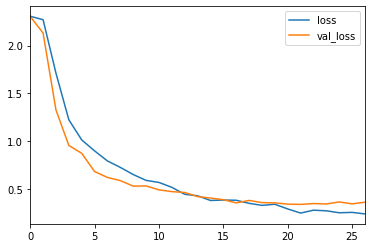

In [34]:
loss = pd.DataFrame(model.history.history)
loss.plot()

** Na podstawie powyższego wykresu stwierdzono, że nauczenie się sieci skończyło przed rozpoczęciem przeuczenia się - wzrost wartości cost function dla validation datasetu oraz zmniejszenie wartości cost function dla train datasetu. **

## Sprawdzenie modelu na danych testowych

** Otrzymanie wyników klasyfikacji według nauczonego modelu dla danych testowych. **

In [35]:
results = model.predict_classes(X_test)

** Porównanie wyników z rzeczywistymi wartościami. **

In [36]:
from sklearn.metrics import classification_report
print(classification_report([int(i) for i in Y_test], results))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



** Jak widać, model bezbłędnie przeprowadził klasyfikację dla danych testowych. **

## Zapis modelu

In [37]:
model.save('vz_sign_numbers.h5')

## Sprawdzenie działania modelu na zdjęciach rzeczywistych

** Postanowiłem sprawdzić działanie modelu dla zrobionych przeze mnie zdjęć dla liczb 1,2,3,5,8. **

### Przygotowanie obrazów dla ich użycia przez model

** Analogiczne postępowania, jak i dla train i validation dataset. ** 

In [38]:
X_my_own = []
Y_my_own = []
dir_with_my_images = '/home/vazh/Desktop/IDL/My_own_images'

for image in os.listdir(dir_with_my_images):
    X_my_own.append(imread(dir_with_my_images + '/' + image))
    Y_my_own.append(image.split('_')[0])

for i in range(0,len(X_my_own)):
    X_my_own[i] = cv2.resize(X_my_own[i], (100, 100))
    X_my_own[i] = X_my_own[i]/255
    X_my_own[i].tolist()

X_my_own = np.array(X_my_own)

predict_my_own = model.predict_classes(X_my_own)

** Przykład kilku obrazków. **

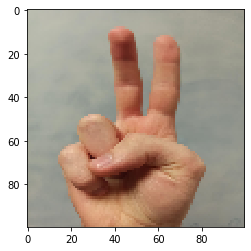

In [39]:
plt.imshow(X_my_own[0])

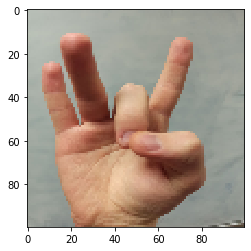

In [40]:
plt.imshow(X_my_own[4])

** Porównanie wyników z rzeczywistymi wartościami. **

In [41]:
print(classification_report([int(i) for i in Y_my_own], predict_my_own))

              precision    recall  f1-score   support

           1       1.00      0.50      0.67         2
           2       1.00      0.50      0.67         2
           3       0.50      1.00      0.67         1
           5       0.75      1.00      0.86         3
           8       1.00      0.50      0.67         2
           9       0.00      0.00      0.00         0

    accuracy                           0.70        10
   macro avg       0.71      0.58      0.59        10
weighted avg       0.88      0.70      0.72        10



/home/vazh/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** Wyniki według modelu. **

In [42]:
print(predict_my_own)

[2 3 5 5 8 5 1 3 5 9]


** Wyniki rzeczywiste. **

In [43]:
print(Y_my_own)

['2', '1', '5', '5', '8', '5', '1', '3', '2', '8']


** Otrzymano wynik z 70% dokładnością modelu. Dokonane błędy przez model: 
 - zamiast 1 postanowił, że to 3
 - zamiast 2 postanowił, że to 5
 - zamiast 8 postanowił, że to 9

** Zdjęcia, dla których model przepowiedział złe wartości. **

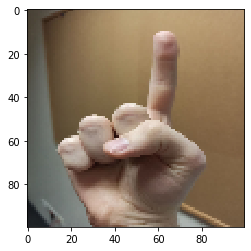

In [44]:
plt.imshow(X_my_own[1])

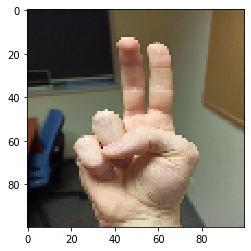

In [45]:
plt.imshow(X_my_own[-2])

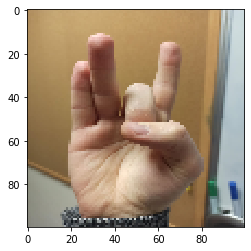

In [46]:
plt.imshow(X_my_own[-1])

** Wytłumaczeniem, czemu model w tych przypadkach zadział źle, może być ten fakt, że wszystkie zdjęcia w danych dla nauczenia sieci były zrobione na białym tle, a z 10 zrobionych przeze mnie zdjęć, tylko 6 było na białym tle, a 4 były zrobione na dowolnym tle. I dla 3 zdjęć z tych 4 model przepowiedział złą wartość. Polepszyć działanie modelu można by było poprzez przygotowanie zdjęć dla nauczenia sieci na różnych tłach. **

## Podsumowanie

1) Przygotowano dane dla nauczenia sieci neuronowej poprzez przeprowadzenie konwersji .jpg obrazków do postaci numpy array, przeskalowanie oraz ustawienie jednego rozmiaru (100, 100, 3) dla wszystkich obrazków. Przeprowadzono podział danych dla uczenia sieci na train dataset (85% od wszystkich zdjęć) oraz validation dataset (15% od wszystkich zdjęć).

2) Stworzono model sieci neuronowej, wykorzystując:
- trzy pary warstw Convolutional2D/MaxPooling2D z rozmiarem kernela (2,2), funkcją aktywacji ReLU oraz ze zmniejszającą się liczbą filtrów o połowę, zaczynając od 32;  
- warstwę Flatten w celu stworzenia liniowości;
- dwie pary warstwy Dense fully-connected/Dropout (z rate = 0.1) ze zmniejszająca się liczbą neuronów o połowę zaczynając od 32 wraz z funkcją aktywacji ReLU;
- jako warstwę output Dense z liczbą neuronów 10 oraz funkcją aktywacji softmax;
- optymizator Adam i jako cost function categorical crossentropy;
- EarlyStopping, z poszukiwaniem minimum cost function dla validation dataset ora z minimalną liczbę epoch 5;

3) Nauczono sieć neuronową o takim modelu jak powyżej, wykorzystując przygotowane train i validation datasety. Nauczenie się sieci skończyło po 27 kroku (EarlyStopping).

4) Sprawdzono działanie modelu na danych testowych. Model bezbłędnie przeprowadził klasyfikację dla danych testowych.

5) Sprawdzono działanie modelu na zdjęciach rzeczywistych (wykonanych przeze mnie). Dokładność modelu wynosiła 70%. Stwierdzono, że zwiększyć dokładność modelu można by było, poprzez dodanie do datasetu dla nauczenia sieci zdjęć zrobionych na innych tłach niż biały.  